# Mock population

In this notebook we generate a mock catalog of GW events

In [1]:
#IMPORT
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import scipy.stats as stats
import time


#PYTHON MODULES
from spectral_sirens.utils.constants import *
from spectral_sirens.cosmology import gwcosmo
from spectral_sirens.gw_population import gwpop
from spectral_sirens.utils import gwutils
from spectral_sirens.utils import utils
from spectral_sirens.detectors import sensitivity_curves as sc

#Directories
import os 
PATH = os.getcwd()
catalog = 'powerlaw_peak'
dir_out = 'data_mock_catalogues/'+catalog+'/'

#PLOTS
from matplotlib.ticker import ScalarFormatter
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

---
## Fiducial model

We choose our fiducial universe to have populations of BHs and NSs that are consistent with the gravitational-wave observations of LIGO--Virgo--KAGRA as of GWTC-3 (https://arxiv.org/abs/2111.03634) 

In [2]:
#Fiducial universe
from fiducial_universe_gwtc3 import *
model_name = 'powerlaw_peak_smooth_alpha_%s_sig_%s_mu_%s_fpeak_%s_mmin_pl_%s_mmax_pl_%s_mmin_filt_%s_mmax_filt_%s_dmmin_%s_dmmax_%s '%(alpha_fid, sig_m1_fid, mu_m1_fid, f_peak_fid, mmin_pl_fid, mmax_pl_fid, mMin_filter_fid,mMax_filter_fid,dmMin_filter_fid,dmMax_filter_fid)

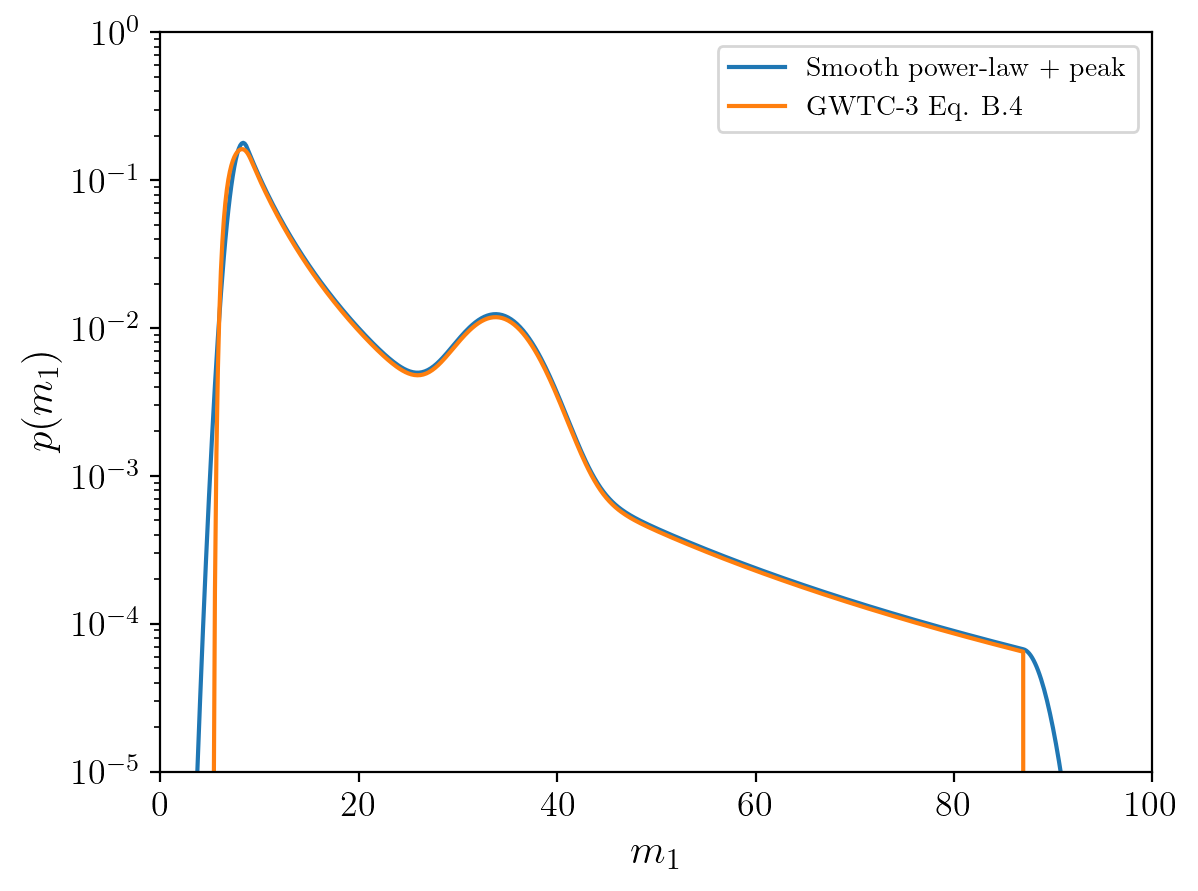

In [30]:
ms = np.linspace(0.1, 150, 1000)
pm = gwpop.powerlaw_peak_smooth(ms,mmin_pl_fid,mmax_pl_fid,alpha_fid,sig_m1_fid,mu_m1_fid,f_peak_fid,mMin_filter_fid,mMax_filter_fid,dmMin_filter_fid,dmMax_filter_fid)
pm = pm/np.trapz(pm,ms)

mmin_fid = 5.
mmax_fid = 87.
alpha_fid = -3.4
f_peak_fid = 0.04
mu_peak_fid = 34.
sig_peak_fid = 3.6
deltaM_fid = 4.8
pm_gwtc3 = gwpop.powerlaw_peak_gwtc3(ms, mmin_fid, mmax_fid, alpha_fid, sig_peak_fid, mu_peak_fid, f_peak_fid, deltaM_fid)
pm_gwtc3 = pm_gwtc3/np.trapz(pm_gwtc3,ms)

plt.plot(ms, pm,label='Smooth power-law + peak')
plt.plot(ms, pm_gwtc3,label='GWTC-3 Eq. B.4')
plt.xlabel(r'$m_1$',fontsize=fontSz)
plt.ylabel(r'$p(m_1)$',fontsize=fontSz)
plt.tick_params(axis='both', which='major', labelsize=fontsz)
plt.yscale('log')
plt.ylim(1e-5,1e0)
plt.xlim(0,100)
plt.legend()
plt.show()

---
## Simulating the population

In [8]:
#Mock catalogue parameters
n_detections = 100
n_samples = 100
n_sources = n_detections*10
#random_seed = np.random.seed(2)

In [9]:
fmin = 10.
Tobs = 1.
detector = 'A#'
based = 'ground'
snr_th = 8.0

We define the source populations in source masses and redshift.

In this case we choose:
- Refshift: SFR like function
- Primary mass: smooth power-law+peak model
- Secondary mass: uniform in mass ratio

In [10]:
def mock_source_parameters(n_sources,H0,Om0,mMin_pl,mMax_pl,alpha,sig_m1,mu_m1,f_peak,mMin_filter,mMax_filter,dmMin_filter,dmMax_filter,zp,alpha_z,beta):
    zs = np.linspace(0.01,10,1000)
    cdf_z = cumtrapz(gwcosmo.diff_comoving_volume_approx(zs,H0,Om0)*gwpop.rate_z(zs,zp,alpha_z,beta)/(1+zs),zs,initial=0)
    cdf_z /= cdf_z[-1]
    masses = np.linspace(mMin_pl,mMax_pl,1000)
    cdf_m1 = cumtrapz(gwpop.powerlaw_peak_smooth(masses,mMin_pl,mMax_pl,alpha,sig_m1,mu_m1,f_peak,mMin_filter,mMax_filter,dmMin_filter,dmMax_filter),masses,initial=0)
    cdf_m1 /= cdf_m1[-1]

    z_mock = utils.inverse_transf_sampling(cdf_z,zs,n_sources)
    m1_mock = utils.inverse_transf_sampling(cdf_m1,masses,n_sources)
    q_mock = np.random.uniform(0,1,n_sources)
    m2_mock = m1_mock * q_mock
    dL_mock = gwcosmo.dL_approx(z_mock,H0,Om0)
    m1z_mock = (1 + z_mock) * m1_mock
    m2z_mock = (1 + z_mock) * m2_mock
    return m1z_mock, m2z_mock, dL_mock

When computing the mock detections we follow the recipe of https://arxiv.org/pdf/1911.05882.pdf to estimate the observed posteriors

In [11]:
def mock_population(n_sources,n_detections,n_samples,H0,Om0,mMin_pl,mMax_pl,alpha,sig_m1,mu_m1,f_peak,mMin_filter,mMax_filter,dmMin_filter,dmMax_filter,zp,alpha_z,beta,snr_th,fmin,Tobs,detector,*args):
    #n_sources : number of sources to run code
    #n_samples : number of posterior samples per detection
    
    #Mock source paramters
    ww = np.linspace(0.0,1.0,1000)
    cdf_ww = 1.0-sc.pw_hl(ww)
    m1z_mock_pop, m2z_mock_pop, dL_mock_pop = mock_source_parameters(n_sources,H0,Om0,mMin_pl,mMax_pl,alpha,sig_m1,mu_m1,f_peak,mMin_filter,mMax_filter,dmMin_filter,dmMax_filter,zp,alpha_z,beta)
    
    #SNR calcultion: optimal SNR -> true SNR -> observed SNR
    snr_opt_mock_pop = gwutils.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs,detector,based)
    w_mock_pop = utils.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
    snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
    snr_obs_mock_pop = gwutils.observed_snr(snr_true_mock_pop)

    #Detected population
    detected = snr_obs_mock_pop > snr_th
    snr_opt_mock = snr_opt_mock_pop[detected]
    snr_true_mock = snr_true_mock_pop[detected]
    snr_obs_mock = snr_obs_mock_pop[detected]
    m1z_mock = m1z_mock_pop[detected]
    m2z_mock = m2z_mock_pop[detected]
    dL_mock = dL_mock_pop[detected]
    
    snr_opt_mock = snr_opt_mock_pop[detected]
    snr_true_mock = snr_true_mock_pop[detected]
    snr_obs_mock = snr_obs_mock_pop[detected]
    m1z_mock = m1z_mock_pop[detected]
    m2z_mock = m2z_mock_pop[detected]
    dL_mock = dL_mock_pop[detected]
    
    while np.size(snr_opt_mock) < n_detections:    
        m1z_mock_pop, m2z_mock_pop, dL_mock_pop = mock_source_parameters(n_sources,H0,Om0,mMin_pl,mMax_pl,alpha,sig_m1,mu_m1,f_peak,mMin_filter,mMax_filter,dmMin_filter,dmMax_filter,zp,alpha_z,beta)
        snr_opt_mock_pop = gwutils.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs,detector,based)
        w_mock_pop = utils.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
        snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
        snr_obs_mock_pop = gwutils.observed_snr(snr_true_mock_pop)
    
        detected = snr_obs_mock_pop > snr_th
        snr_opt_mock_add = snr_opt_mock_pop[detected]
        snr_true_mock_add = snr_true_mock_pop[detected]
        snr_obs_mock_add = snr_obs_mock_pop[detected]
        m1z_mock_add = m1z_mock_pop[detected]
        m2z_mock_add = m2z_mock_pop[detected]
        dL_mock_add = dL_mock_pop[detected]
    
        snr_opt_mock = np.append(snr_opt_mock,snr_opt_mock_add)
        snr_true_mock = np.append(snr_true_mock,snr_true_mock_add)
        snr_obs_mock = np.append(snr_obs_mock,snr_obs_mock_add)
        m1z_mock = np.append(m1z_mock,m1z_mock_add)
        m2z_mock = np.append(m2z_mock,m2z_mock_add)
        dL_mock = np.append(dL_mock,dL_mock_add)
    
    snr_opt_mock_det = snr_opt_mock[0:n_detections]
    snr_true_mock_det = snr_true_mock[0:n_detections]
    snr_obs_mock_det = snr_obs_mock[0:n_detections]
    m1z_mock_det = m1z_mock[0:n_detections] 
    m2z_mock_det = m2z_mock[0:n_detections]
    dL_mock_det = dL_mock[0:n_detections]
    
    m1z_mock_samples = np.zeros((n_detections,n_samples))
    m2z_mock_samples = np.zeros((n_detections,n_samples))
    dL_mock_samples = np.zeros((n_detections,n_samples))
    pdraw_mock_samples = np.zeros((n_detections,n_samples))
    for i in range(n_detections):
        m1z_mock_samples[i,:], m2z_mock_samples[i,:], dL_mock_samples[i,:], pdraw_mock_samples[i,:] = gwutils.observed_posteriors(n_samples,
                                                          m1z_mock_det[i],
                                                          m2z_mock_det[i],
                                                          dL_mock_det[i],
                                                          snr_opt_mock_det[i],
                                                          snr_true_mock_det[i],
                                                          snr_obs_mock_det[i],
                                                          snr_th,
                                                          fmin,
                                                          Tobs,
                                                          detector,
                                                          *args)
        
    return m1z_mock_samples, m2z_mock_samples, dL_mock_samples, pdraw_mock_samples

In [12]:
#Run mock population
m1z_mock_samples = np.zeros((n_detections,n_samples))
m2z_mock_samples = np.zeros((n_detections,n_samples))
dL_mock_samples = np.zeros((n_detections,n_samples))
pdraw_mock_samples = np.zeros((n_detections,n_samples))

starttime = time.time()
m1z_mock_samples,m2z_mock_samples,dL_mock_samples,pdraw_mock_samples = mock_population(n_sources,
                                        n_detections,
                                        n_samples,
                                        H0_fid,
                                        Om0_fid,
                                        mmin_pl_fid,
                                        mmax_pl_fid,
                                        alpha_fid,
                                        sig_m1_fid,
                                        mu_m1_fid,
                                        f_peak_fid,
                                        mMin_filter_fid,
                                        mMax_filter_fid,
                                        dmMin_filter_fid,
                                        dmMax_filter_fid,
                                        zp_fid,
                                        alpha_z_fid,
                                        beta_fid,
                                        snr_th,
                                        fmin,
                                        Tobs,
                                        detector,
                                        based)
print('Time taken = {} seconds'.format(time.time() - starttime))

Time taken = 173.0604166984558 seconds


In [ ]:
#Save data
###########
np.save(f'{PATH}'+dir_out+'m1z_'+detector+'_Ndet_%s_Nsamples_%s_'% (n_detections,n_samples)+model_name,m1z_mock_samples)
np.save(f'{PATH}'+dir_out+'m2z_'+detector+'_Ndet_%s_Nsamples_%s_'% (n_detections,n_samples)+model_name,m2z_mock_samples)
np.save(f'{PATH}'+dir_out+'dL_'+detector+'_Ndet_%s_Nsamples_%s_'% (n_detections,n_samples) +model_name,dL_mock_samples)
np.save(f'{PATH}'+dir_out+'pdraw_'+detector+'_Ndet_%s_Nsamples_%s_'% (n_detections,n_samples)+model_name,pdraw_mock_samples)